In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats
import zfit_physics as zphys

import zfit
from zfit import z
from particle import Particle
from scipy.constants import alpha
from mendeleev import Al
from math import pi
import uproot
import matplotlib.pyplot as plt

In [2]:
import pickle

df_eminus = pickle.load( open( "df.pickle", "rb" ) )

In [3]:
obs = zfit.Space('x', limits=(-10, 10))
mu_true = 0
sigma_true = 1

data_res = df_eminus['res'].to_numpy()
data = zfit.data.Data.from_numpy(obs=obs, array=data_res)

In [4]:
mu = zfit.Parameter("mu", 0, -1., 1)
sigma = zfit.Parameter("sigma", 1.3, 0, 5.)
alphal = zfit.Parameter("alphal", 1, 0, 5)
alphar = zfit.Parameter("alphar", 1, 0, 5)
nr = zfit.Parameter("nr", 5, 0, 50)
nl = zfit.Parameter("nl", 20, 0, 5)


In [5]:
dscb = zfit.models.physics.DoubleCB(obs=obs, mu=mu, sigma=sigma,alphal=alphal, nl=nl, alphar=alphar, nr=nr)

In [6]:
# Create the negative log likelihood

nll = zfit.loss.UnbinnedNLL(model=dscb, data=data, fit_range=(-10,10))  # loss

# Load and instantiate a minimizer
minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)
# Get the fitted values, again by run the variable graphs
params = minimum.params

------------------------------------------------------------------
| FCN = 3.06E+04                |     Ncalls=214 (214 total)     |
| EDM = 5.52E-05 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


tf.Tensor([6.14973294e-12], shape=(1,), dtype=float64)


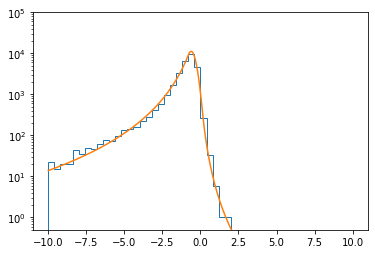

In [7]:
n_bins = 50
range_ = (-10,10)
_ = plt.hist(data_res, bins=n_bins, range=range_, histtype='step', )
x = np.linspace(*range_, num=1000)
with dscb.set_norm_range(range_):
    pdf = zfit.run(dscb.pdf(x))
_ = plt.plot(x, data_res.shape[0] / n_bins * (range_[1] - range_[0]) * pdf)

plt.yscale('log')
plt.ylim(0.5, 100000)
print(dscb.pdf(100))

In [8]:
mu.floating = False
sigma.floating = False
alphal.floating = False
alphar.floating = False
nr.floating = False
nl.floating = False

In [9]:
total_electrons = 564554.6615075701
n_cuts, eff_bins = np.histogram(df_eminus["demcgen_mom"], range=(95,115), bins=80)
efficiency = n_cuts/(total_electrons/80)
efficiency = np.insert(efficiency, 0, 0, axis=0)
efficiency = np.insert(efficiency, len(efficiency), 0, axis=0)

In [10]:
obs_spectrum = zfit.Space('x', limits=(95, 115))
zfit.settings.options['numerical_grad'] = True

class BinnedEfficiencyFunc(zfit.func.ZFunc):
    _PARAMS = []

    def __init__(self, efficiency, eff_bins, obs, name='BinnedEfficiencyFunc'):
        self.efficiency = efficiency
        self.eff_bins = eff_bins
        super().__init__(obs=obs, name=name)
        
    def _binContent(self, x):
        eff_bin = np.digitize(x, self.eff_bins)
        return self.efficiency[eff_bin]
   
    def _func(self, x):
        x = zfit.ztf.unstack_x(x)
        probs = z.py_function(func=self._binContent, inp=[x], Tout=tf.float64)
        probs.set_shape(x.shape)
        return probs

In [11]:
muon = Particle.from_pdgid(13)
proton = Particle.from_pdgid(2212)
electron = Particle.from_pdgid(11)

bound_energy = Al.atomic_number**2 * alpha**2 * muon.mass / 2
recoil_energy = muon.mass**2/(2 * Al.mass * proton.mass)
eMax = muon.mass - bound_energy - recoil_energy

class CESpectrumPDF(zfit.pdf.ZPDF):
    _PARAMS = []  # the name of the parameters

    def _unnormalized_pdf(self, x): 
        x = zfit.ztf.unstack_x(x)
        
        me = zfit.ztf.constant(electron.mass)
        eMax = zfit.ztf.constant(muon.mass - bound_energy - recoil_energy)
        alpha_c = zfit.ztf.constant(alpha)
        pi_c = zfit.ztf.constant(pi)
        
        E = zfit.ztf.sqrt(x * x + me * me)
        result = (1. / eMax) * (alpha_c / (2 * pi_c)) * (zfit.ztf.log(4 * E * E / me / me) - 2.) * ((E * E + eMax * eMax) / eMax / (eMax - E))
        
        return tf.maximum(result, tf.zeros_like(result))

In [12]:
efficiencyFunc = BinnedEfficiencyFunc(efficiency, eff_bins, obs_spectrum)
efficiencyPDF = efficiencyFunc.as_pdf()
efficiencyPDF.set_norm_range(obs_spectrum)
yieldCE = zfit.Parameter("yieldCE", 50, 0, 1000)

ce = CESpectrumPDF(obs=obs_spectrum)
# extended_ce = ce.create_extended(yieldCE)

ce_eff = ce*efficiencyPDF
ce_convoluted = zphys.unstable.pdf.NumConvPDFUnbinnedV1(obs=obs_spectrum, func=ce_eff, kernel=dscb, limits=obs_spectrum)


NameError: name 'CEyield' is not defined

In [13]:
ce_convoluted._set_yield(yieldCE)

In [14]:
sampler = ce_convoluted.create_sampler(n=55)
sampler.resample()

In [15]:
# sampler_spectrum = ce_eff.create_sampler(n=100)
# sampler_spectrum.resample()

In [16]:
data_conv = zfit.run(sampler)
# data_spectrum = zfit.run(sampler_spectrum)

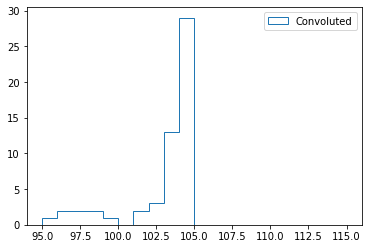

In [17]:
plt.hist(data_conv, bins=20, range=(95,115), histtype='step', label='Convoluted')
# plt.hist(data_spectrum, bins=20, range=(95, 115), histtype='step', label='True')
plt.legend()

In [18]:
df = pickle.load(open( "df_run.pickle", "rb" ))

56


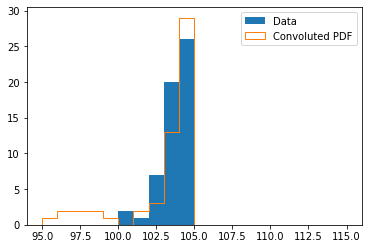

In [19]:
data_mom = df['deent_mom'].to_numpy()
print(len(data_mom))
data_mom_zfit = zfit.data.Data.from_numpy(obs=obs_spectrum, array=data_mom)
plt.hist(data_mom, bins=20, range=(95,115), label='Data')
plt.hist(data_conv, bins=20, range=(95,115), histtype='step', label='Convoluted PDF')
_ = plt.legend()

In [20]:
%load_ext wurlitzer
nll_ce = zfit.loss.ExtendedUnbinnedNLL(model=ce_convoluted, data=data_mom_zfit, fit_range=(95, 115))  # loss
minimizer_ce = zfit.minimize.Minuit(verbosity=7, use_minuit_grad=True)
minimum_ce = minimizer_ce.minimize(loss=nll_ce)
params_ce = minimum_ce.params

------------------------------------------------------------------
| FCN = -100.6                  |      Ncalls=15 (15 total)      |
| EDM = 0.00038 (Goal: 5E-05)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


In [39]:
print(minimum_ce.error(yieldCE)[yieldCE].lower)

-6.949739701878311


In [33]:
print(params_ce[yieldCE]['minuit_hesse'])

{'error': 7.460910830523055}


W0305 11:17:46.613054 4683828672 def_function.py:586] 5 out of the last 5 calls to <function BasePDF.pdf at 0x145eaf680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


(0.5, 88.74279246246144)

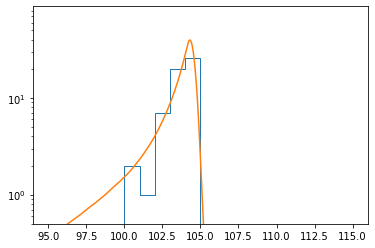

In [22]:
n_bins = 20
range_ = (95,115)
_ = plt.hist(data_mom, bins=n_bins, range=range_, histtype='step', )
x = np.linspace(*range_, num=1000)
with ce_convoluted.set_norm_range(range_):
    pdf = zfit.run(ce_convoluted.pdf(x))
_ = plt.plot(x, data_mom.shape[0] / n_bins * (range_[1] - range_[0]) * pdf)

plt.yscale('log')
plt.ylim(bottom=0.5)

In [25]:
zfit.run(ce_convoluted.integrate((90,110)))

1.006790995092662